Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [2]:
df=pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


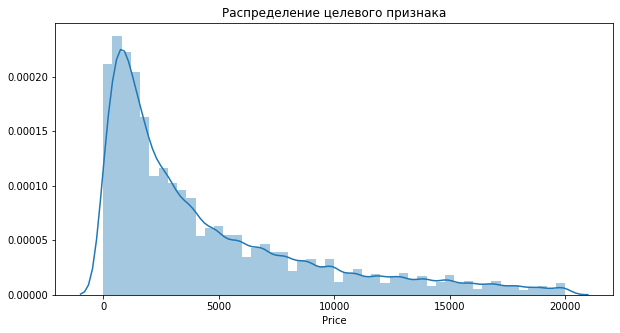

In [5]:
# Распределение целевого признака
plt.figure(figsize=(10,5))
plt.title('Распределение целевого признака')
sns.distplot(df['Price'])

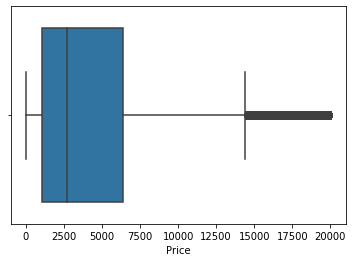

In [6]:
sns.boxplot(df['Price'])

- Удалим все NaN.
- Удалим выбросы по цене. Убаляю все что меньше первого квантиля

In [7]:
df=df.dropna()
df=df.loc[(df['Price']>1000) &(df['Price']<20000)]

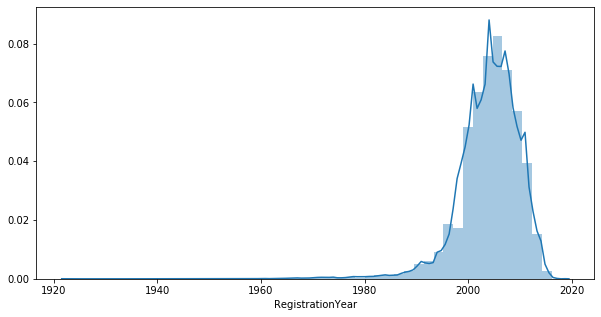

In [8]:
plt.figure(figsize=(10,5))
sns.distplot(df['RegistrationYear'])

Удалим выбросы по году регистрации все что меньше 1980 года

In [9]:
df=df.loc[(df['RegistrationYear']>1980)]

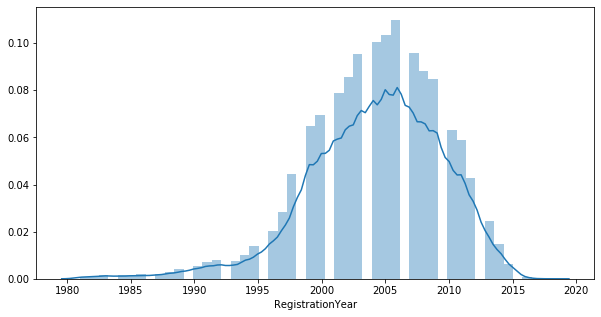

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(df['RegistrationYear'])

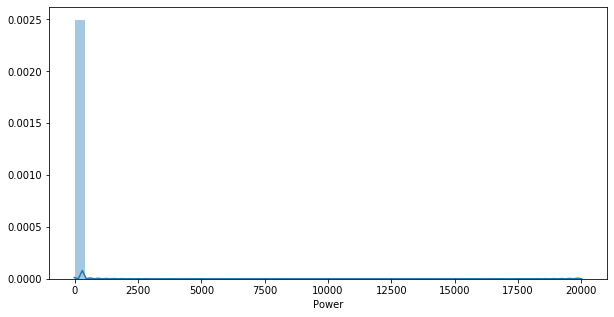

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(df['Power'])

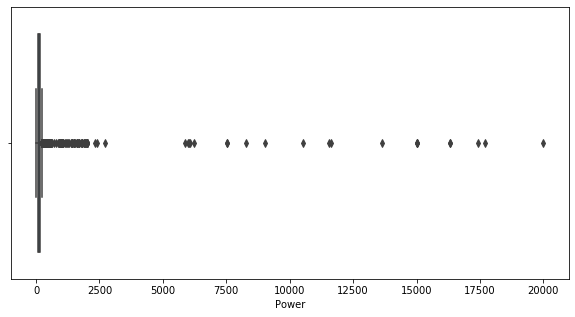

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(df['Power'])

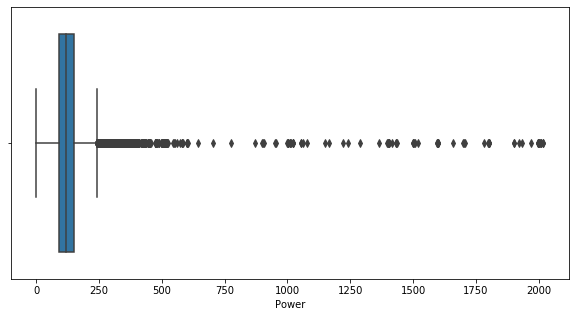

In [13]:
temp = df.loc[(df['Power']<2300)]
plt.figure(figsize=(10,5))
sns.boxplot(temp['Power'])

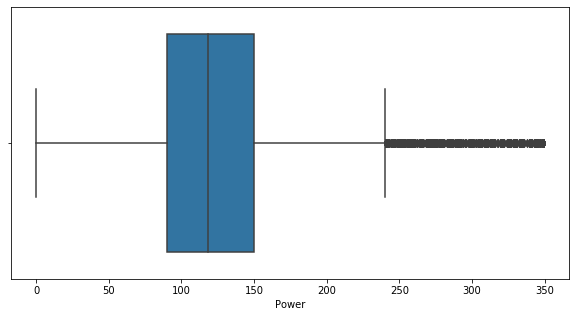

In [14]:
temp = df.loc[(df['Power']<350)]
plt.figure(figsize=(10,5))
sns.boxplot(temp['Power'])

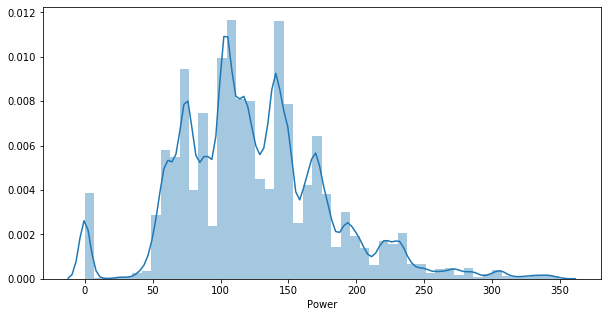

In [15]:
plt.figure(figsize=(10,5))
sns.distplot(temp['Power'])

Удалим выбросы по мощности

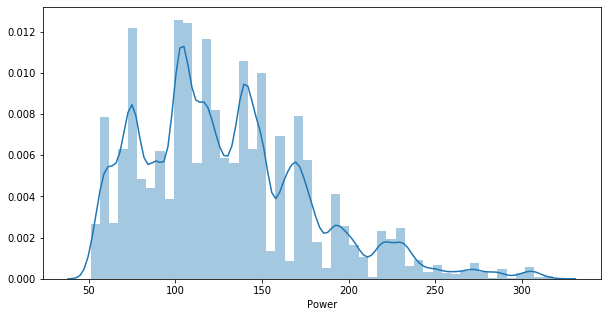

In [16]:
# Удаляю выбросы по мощности
df=df.loc[(df['Power']>50)&(df['Power']<320)]
plt.figure(figsize=(10,5))
sns.distplot(df['Power'])

In [17]:
df.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190818 entries, 3 to 354367
Data columns (total 16 columns):
DateCrawled          190818 non-null object
Price                190818 non-null int64
VehicleType          190818 non-null object
RegistrationYear     190818 non-null int64
Gearbox              190818 non-null object
Power                190818 non-null int64
Model                190818 non-null object
Kilometer            190818 non-null int64
RegistrationMonth    190818 non-null int64
FuelType             190818 non-null object
Brand                190818 non-null object
NotRepaired          190818 non-null object
DateCreated          190818 non-null object
NumberOfPictures     190818 non-null int64
PostalCode           190818 non-null int64
LastSeen             190818 non-null object
dtypes: int64(7), object(9)
memory usage: 24.7+ MB


In [19]:
df['DateCrawled']=pd.to_datetime(df['DateCrawled'])
df['DateCreated']=pd.to_datetime(df['DateCreated'])
df['LastSeen']=pd.to_datetime(df['LastSeen'])
#Сколько дней между датой последней активности и датой создания объявления
print((df['LastSeen']-df['DateCreated']).dt.round('1D'))
print('-----------------')
#Сколько дней между датой скачивания и датой создания объявления
print((df['DateCrawled']-df['DateCreated']).dt.round('1D'))

3         1 days
4         6 days
6         5 days
10       11 days
11        0 days
           ...  
354355   17 days
354359    6 days
354362    1 days
354366    7 days
354367   19 days
Length: 190818, dtype: timedelta64[ns]
-----------------
3        1 days
4        1 days
6        1 days
10       1 days
11       0 days
          ...  
354355   1 days
354359   1 days
354362   1 days
354366   1 days
354367   1 days
Length: 190818, dtype: timedelta64[ns]


In [20]:
#Удаляю столбы
del df['LastSeen']
del df['DateCreated']
del df['DateCrawled']
del df['RegistrationMonth']
del df['PostalCode']
del df['NumberOfPictures']

In [21]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


### Выводы
столбцы:
- LastSeen
- DateCreated
- DateCrawled
- RegistrationMonth
- PostalCode
- NumberOfPictures

были удалены из за лишней информацией признаков, которые явно не имеют смысла для предсказания цены а так же влияют на:
- качество предсказания;
- скорость предсказания;
- время обучения.

>Так же были удалены выбросы и NaN

# 2. Обучение моделей

Напишем функцию которой на вход будут подаваться модель и датасеты и она будет возвращать время обучения, время предсказания и rmse

In [22]:
def model_eval(model, train_features, train_target, test_features, test_tagret):
    
    start = time.time()    
    model.fit(train_features, train_target)
    training_time = time.time() - start
    
    start = time.time()  
    predict = model.predict(test_features)
    predict_time = time.time() - start

    return training_time, predict_time, mse(test_tagret, predict)**0.5

In [23]:
res=[]
target=df['Price']
features=df.drop(['Price'],axis=1)


train_features,test_features,train_target,test_tagret = train_test_split(features,
                                                                         target,
                                                                         test_size=0.2,
                                                                         random_state=12345)

train_valid_features,valid_features,train_valid_target,valid_tagret = train_test_split(train_features,
                                                                         train_target,
                                                                         test_size=0.2,
                                                                         random_state=12345)


### Ridge
- Подготовим пайплайн: OHE -> scaler -> ridge
- На кросс валидации найдем лучшие параметры модели
- Измерим время обучения и запишем результаты на тесте.

In [24]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', Ridge(random_state=12345))
])

params = [
    {
        'model__alpha': np.logspace(-2, 2, 20)
    } 
]

In [25]:
cv = KFold(n_splits=3, shuffle=True, random_state=12345)

grid = GridSearchCV(pipe,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [26]:
%%time
grid.fit(train_valid_features, train_valid_target);

CPU times: user 4min 7s, sys: 1.19 s, total: 4min 8s
Wall time: 4min 11s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(categorical_features=None,
                                                      categories=None,
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='ignore',
                                                      n_values=None,
                                                      sparse=True)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=...
       6.95192796e

In [27]:
grid.best_params_

{'model__alpha': 2.06913808111479}

In [28]:
res.append(model_eval(grid.best_estimator_,train_valid_features, train_valid_target, valid_features, valid_tagret))


###  LightGBM  regressor

In [29]:
# Нахожу категориальные признаки
cat_features_index=np.where(features.dtypes==np.object)
cat_features_index

(array([0, 2, 4, 6, 7, 8]),)

In [30]:
categorical_features=features.columns.get_values()[cat_features_index]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """Entry point for launching an IPython kernel.


In [31]:
categorical_features

array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'NotRepaired'], dtype=object)

In [32]:
# Произвожу перевод категориальные признаки с помощью OHE
features_lbm=pd.get_dummies(features,columns=categorical_features,drop_first=True)

In [33]:
train_features_lbm, test_features_lbm, train_target_lbm, test_tagret_lbm = train_test_split(
    features_lbm,target,test_size=0.2,random_state=1234)

train_valid_features_lbm, valid_features_lbm, train_valid_target_lbm, valid_tagret_lbm = train_test_split(
    train_features_lbm,train_target_lbm,test_size=0.2,random_state=12345)



In [34]:
gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=12345)


params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}

grid_gbm = GridSearchCV(gbm,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=True)

In [35]:
%%time
grid_gbm.fit(train_valid_features_lbm, train_valid_target_lbm);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  8.6min finished


CPU times: user 8min 18s, sys: 18.2 s, total: 8min 36s
Wall time: 8min 41s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective...
                                     reg_alpha=0.0, reg_lambda=0.0, seed=12345,
                                     silent=True, subsample=1.0,
                                     subsample_for_bin=200000, subsample_freq=0,
                                     verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': array([0.001     , 0.005623

In [36]:
grid_gbm.best_params_

{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 41}

In [37]:

res.append(model_eval(grid_gbm.best_estimator_, train_valid_features_lbm, train_valid_target_lbm, valid_features_lbm, valid_tagret_lbm))


### CatBoostingRegressor

In [38]:
cbr = CatBoostRegressor(random_seed=12345,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=categorical_features)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [39]:
%%time
grid_cbr.fit(train_valid_features, train_valid_target);

CPU times: user 12min 48s, sys: 1min 50s, total: 14min 39s
Wall time: 16min 8s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f284a5929d0>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=False)

In [40]:
grid_cbr.best_params_

{'depth': 10, 'iterations': 60, 'learning_rate': 1.0}

In [41]:
res.append(model_eval(grid_cbr.best_estimator_, 
                      train_valid_features, 
                      train_valid_target, 
                      valid_features, 
                      valid_tagret))


# 3. Анализ моделей

Сведем все данные в один датафрейм и посмотрим результаты на валидационной выборке

Для выбранной модели посмотрим результат на тесте

In [42]:
pd.DataFrame(data=res,
             index=['Ridge', 'LightGBM', 'CatBoost'],
             columns=['trainig_time', 'predic_time', 'score'])

,trainig_time,predic_time,score
Ridge,6.306030,0.071847,1979.211101
LightGBM,5.595055,0.497396,1642.580751
CatBoost,18.571190,0.116002,1617.882462


В данном случае наиболее подходящей моделью, с оптимальным качеством и быстродействием оказался: LightGBM

Проверим метрику на тесте

In [45]:
model = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=12345)
model.fit(train_features_lbm, train_target_lbm)
mse(test_tagret_lbm, model.predict(test_features_lbm))**0.5

1659.886791688802